In [4]:


suppressMessages(library(dplyr))
suppressMessages(library(Seurat))
suppressMessages(library(viridis))
suppressMessages(library(ConsensusClusterPlus))
suppressMessages(library(magrittr))
suppressMessages(library(ArchR))

In [13]:
#### CellTrek Functions ####
# traint ####
traint_v5 <- function (
    st_data, sc_data, st_assay='Spatial', sc_assay='scint', 
    norm='LogNormalize', nfeatures=2000, 
    cell_names='cell_names', coord_xy=c('imagerow', 'imagecol'), 
    gene_kept=NULL, ...) {
    
    st_data$id <- names(st_data$orig.ident)
    sc_data$id <- names(sc_data$orig.ident)
    sc_data$cell_names <- make.names(sc_data@meta.data[, cell_names])
    st_data$type <- 'st'
    sc_data$type <- 'sc'
    st_data$coord_x <- st_data@images[[1]]@coordinates[, coord_xy[1]]
    st_data$coord_y <- st_data@images[[1]]@coordinates[, coord_xy[2]]
    DefaultAssay(st_data) <- st_assay
    DefaultAssay(sc_data) <- sc_assay

    cat('Finding transfer anchors... \n')
    st_idx <- st_data$id
    sc_idx <- sc_data$id

    ## Integration features ##
    sc_st_list <- list(st_data=st_data, sc_data=sc_data)
    sc_st_features <- Seurat::SelectIntegrationFeatures(
      sc_st_list, nfeatures=nfeatures)
    if (!is.null(gene_kept)) {
      sc_st_features <- union(sc_st_features, gene_kept)
    }

    sc_st_features <- 
      sc_st_features[(sc_st_features %in% rownames(st_data)) & (sc_st_features %in% rownames(sc_data))]
    
    # sc_st_features <- 
    #   sc_st_features[(sc_st_features %in% rownames(st_data[[st_assay]]@data)) & 
    #                    (sc_st_features %in% rownames(sc_data[[sc_assay]]@data))]
    
    cat('Using', length(sc_st_features), 'features for integration... \n')
    ###

    sc_st_anchors <- Seurat::FindTransferAnchors(
        reference = sc_data, 
        query = st_data, 
        reference.assay = sc_assay, 
        query.assay = st_assay,
        normalization.method = norm, 
        features = sc_st_features, 
        reduction = 'cca',
        verbose = FALSE)

    cat('Data transfering... \n')
    st_data_trans <- Seurat::TransferData(
        anchorset = sc_st_anchors, 
        refdata = GetAssayData(sc_data)[sc_st_features, ], 
        weight.reduction = 'cca')

    st_data@assays$transfer <- st_data_trans

    cat('Creating new Seurat object... \n')
    sc_st_meta <- dplyr::bind_rows(st_data@meta.data, sc_data@meta.data)
    counts_temp <- cbind(
      data.frame(st_data[['transfer']]@data),
      data.frame(sc_data[[sc_assay]]@data[sc_st_features, ] %>% data.frame))
    rownames(sc_st_meta) <- make.names(sc_st_meta$id)
    colnames(counts_temp) <- make.names(sc_st_meta$id)
    
    sc_st_int <- CreateSeuratObject(
      counts = counts_temp, 
      assay = 'traint', 
      meta.data = sc_st_meta, 
        project = "SeuratProject"
    )

    cat('Scaling -> PCA -> UMAP... \n')
    sc_st_int <- sc_st_int %>%
        ScaleData(features = sc_st_features, 
                  assay = 'traint', layer = 'counts', verbose = FALSE) %>%
        RunPCA(features = sc_st_features, verbose = FALSE) %>%
        RunUMAP(dims = 1:30, verbose = FALSE)
    
    sc_st_int@images <- st_data@images

    sc_st_int@images[[1]]@coordinates <- data.frame(
      imagerow=sc_st_int@meta.data$coord_x,
      imagecol=sc_st_int@meta.data$coord_y) %>% 
      set_rownames(rownames(sc_st_int@meta.data))

    return (sc_st_int)
}

In [6]:
# celltrek_dist ####
celltrek_dist <- function (
    st_sc_int, int_assay='traint', reduction='pca', intp = T, intp_pnt=10000, 
    intp_lin=F, nPCs=30, ntree=1000, keep_model=T) {
  DefaultAssay(st_sc_int) <- int_assay
  kNN_dist <- dbscan::kNN(
    na.omit(st_sc_int@meta.data[, c('coord_x', 'coord_y')]), k=6)$dist
  spot_dis <- median(kNN_dist) %>% round
  cat('Distance between spots is:', spot_dis, '\n')
  
  st_sc_int$id <- names(st_sc_int$orig.ident)
  st_idx <- st_sc_int$id[st_sc_int$type=='st']
  sc_idx <- st_sc_int$id[st_sc_int$type=='sc']
  meta_df <- data.frame(st_sc_int@meta.data)
  
  st_sc_int_pca <- 
    st_sc_int@reductions[[reduction]]@cell.embeddings[, 1:nPCs] %>% 
    data.frame %>%
    mutate(id=st_sc_int$id, type=st_sc_int$type, class=st_sc_int$cell_names,
           coord_x=st_sc_int$coord_x, coord_y=st_sc_int$coord_y)
  st_pca <- st_sc_int_pca %>% 
    dplyr::filter(type=='st') %>% 
    dplyr::select(-c(id:class))
  
  ## Interpolation ##
  ## Uniform sampling ##
  if (intp) {
    cat ('Interpolating...\n')
    spot_ratio <- intp_pnt/nrow(st_pca)
    st_intp_df <- apply(st_pca[, c('coord_x', 'coord_y')], 1, function(row_x) {
      runif_test <- runif(1)
      if (runif_test < spot_ratio%%1) {
        theta <- runif(ceiling(spot_ratio), 0, 2*pi)
        alpha <- sqrt(runif(ceiling(spot_ratio), 0, 1))
        coord_x <- row_x[1] + (spot_dis/2)*sin(theta)*alpha
        coord_y <- row_x[2] + (spot_dis/2)*cos(theta)*alpha
      } else {
        theta <- runif(floor(spot_ratio), 0, 2*pi)
        alpha <- sqrt(runif(floor(spot_ratio), 0, 1))
        coord_x <- row_x[1] + (spot_dis/2)*sin(theta)*alpha
        coord_y <- row_x[2] + (spot_dis/2)*cos(theta)*alpha
      }
      data.frame(coord_x, coord_y)
    }) %>% Reduce(rbind, .)
    
    st_intp_df <- apply(st_pca[, 1:nPCs], 2, function(col_x) {
      akima::interpp(x=st_pca$coord_x, y=st_pca$coord_y, z=col_x,
                     linear=intp_lin, xo=st_intp_df$coord_x, 
                     yo=st_intp_df$coord_y) %>%
        magrittr::extract2('z')
    }) %>% data.frame(., id='X', type='st_intp', st_intp_df) %>% na.omit
    st_intp_df$id <- make.names(st_intp_df$id, unique = T)
    st_sc_int_pca <- bind_rows(st_sc_int_pca, st_intp_df)
  }
  
  cat('Random Forest training... \n')
  ## Training on ST ##
  data_train <- st_sc_int_pca %>% 
    dplyr::filter(type=='st') %>% 
    dplyr::select(-c(id:class))
  rf_train <- randomForestSRC::rfsrc(
    Multivar(coord_x, coord_y) ~ ., data_train, block.size=5, ntree=ntree)
  
  cat('Random Forest prediction...  \n')
  ## Testing on all ##
  data_test <- st_sc_int_pca
  rf_pred <- randomForestSRC::predict.rfsrc(
    rf_train, newdata=data_test[, c(1:nPCs)], distance='all')
  
  cat('Making distance matrix... \n')
  rf_pred_dist <- 
    rf_pred$distance[data_test$type=='sc', data_test$type!='sc'] %>%
    set_rownames(data_test$id[data_test$type=='sc']) %>% 
    set_colnames(data_test$id[data_test$type!='sc'])
  
  output <- list()
  output$spot_d <- spot_dis
  output$celltrek_dist <- rf_pred_dist
  output$coord_df <- st_sc_int_pca[, c('id', 'type', 'coord_x', 'coord_y')] %>%
    dplyr::filter(type!='sc') %>% 
    magrittr::set_rownames(.$id) %>% 
    dplyr::select(-id)
  if (keep_model) {
    output$model <- rf_train
  }
  return (output)
}

# celltrek_chart ####
celltrek_chart <- function (dist_mat, coord_df, dist_cut=500, top_spot=10, 
                            spot_n=10, repel_r=5, repel_iter=10) {
  cat('Making graph... \n')
  dist_mat[dist_mat>dist_cut] <- NA
  dist_mat_dt <- data.table::data.table(Var1=rownames(dist_mat), dist_mat)
  dist_edge_list <- data.table::melt(dist_mat_dt, id=1, na.rm=T)
  colnames(dist_edge_list) <- c('Var1', 'Var2', 'value')
  dist_edge_list$val_rsc <- scales::rescale(
    dist_edge_list$value, to=c(0, repel_r))
  dist_edge_list$Var1 %<>% as.character
  dist_edge_list$Var2 %<>% as.character
  dist_edge_list$Var1_type <- 'sc'
  dist_edge_list$Var2_type <- 'non-sc'
  
  cat('Pruning graph...\n')
  dist_edge_list_sub <- dplyr::inner_join(
    dist_edge_list %>% 
      group_by(Var1) %>% 
      top_n(n=top_spot, wt=-value), 
    dist_edge_list %>% group_by(Var2) %>% 
      top_n(n=spot_n, wt=-value)) %>% 
    data.frame
  
  cat('Spatial Charting SC data...\n')
  sc_coord <- sc_coord_raw <- data.frame(
    id_raw=dist_edge_list_sub$Var1, id_new=make.names(dist_edge_list_sub$Var1, 
                                                      unique = T))
  sc_coord$coord_x <- 
    sc_coord_raw$coord_x <- 
    coord_df$coord_x[match(dist_edge_list_sub$Var2, rownames(coord_df))]
  sc_coord$coord_y <- 
    sc_coord_raw$coord_y <- 
    coord_df$coord_y[match(dist_edge_list_sub$Var2, rownames(coord_df))]
  ## Add noise ##
  theta <- runif(nrow(dist_edge_list_sub), 0, 2*pi)
  alpha <- sqrt(runif(nrow(dist_edge_list_sub), 0, 1))
  sc_coord$coord_x <- 
    sc_coord$coord_x + dist_edge_list_sub$val_rsc*sin(theta)*alpha
  sc_coord$coord_y <- 
    sc_coord$coord_y + dist_edge_list_sub$val_rsc*cos(theta)*alpha
  ## Point repelling ##
  cat('Repelling points...\n')
  sc_repel_input <- data.frame(
    sc_coord[, c('coord_x', 'coord_y')], repel_r=repel_r)
  sc_repel <- packcircles::circleRepelLayout(
    sc_repel_input, sizetype='radius', maxiter=repel_iter)
  sc_coord$coord_x <- sc_repel$layout$x
  sc_coord$coord_y <- sc_repel$layout$y
  return(list(sc_coord_raw, sc_coord))
}

In [7]:
# celltrek ####
celltrek <- function (
    st_sc_int, int_assay='traint', sc_data=NULL, sc_assay='RNA', 
    reduction='pca', intp=T, intp_pnt=10000, intp_lin=F, nPCs=30, ntree=1000, 
    dist_thresh=.4, top_spot=10, spot_n=10, repel_r=5, repel_iter=10, 
    keep_model=F, ...) {

dist_res <- celltrek_dist(
    st_sc_int=st_sc_int, int_assay=int_assay, reduction=reduction, intp=intp, 
    intp_pnt=intp_pnt, intp_lin=intp_lin, nPCs=nPCs, ntree=ntree, keep_model=T)

spot_dis_intp <- mediaspot_dis_intp <- mediaspot_dis_intp <- median(
  unlist(dbscan::kNN(dist_res$coord_df[, c('coord_x', 'coord_y')], k=4)$dist))

if (is.null(repel_r)) {repel_r=spot_dis_intp/4}

sc_coord_list <- celltrek_chart(
    dist_mat=dist_res$celltrek_dist, coord_df=dist_res$coord_df, 
    dist_cut=ntree*dist_thresh, top_spot=top_spot, spot_n=spot_n, 
    repel_r=repel_r, repel_iter=repel_iter)

    sc_coord_raw <- sc_coord_list[[1]]
    sc_coord <- sc_coord_list[[2]]

    print(head(sc_coord_raw))
    print(head(sc_coord))
    
cat('Creating Seurat Object... \n')
if (!is.null(sc_data)) {
    cat('sc data...')
    sc_data$id <- Seurat::Cells(sc_data)
    
    sc_out <- CreateSeuratObject(
        counts=sc_data[[sc_assay]]@data[, sc_coord$id_raw] %>% set_colnames(sc_coord$id_new), 
        project='celltrek', 
        assay=sc_assay, 
        meta.data=sc_data@meta.data[sc_coord$id_raw, ] %>% 
        dplyr::rename(id_raw=id) %>% 
        mutate(id_new=sc_coord$id_new) %>% 
        set_rownames(sc_coord$id_new))
  
  sc_out@meta.data <- dplyr::left_join(
    sc_out@meta.data, sc_coord) %>% 
    data.frame %>% 
    set_rownames(sc_out$id_new)

  sc_coord_raw_df <- CreateDimReducObject(
    embeddings=sc_coord_raw %>% 
      dplyr::mutate(
        coord1=coord_y, coord2=max(coord_x)+min(coord_x)-coord_x
      ) %>%
      dplyr::select(c(coord1, coord2)) %>% 
      set_rownames(sc_coord_raw$id_new) %>% 
      as.matrix, assay=sc_assay, key='celltrek_raw')
  
  sc_coord_dr <- CreateDimReducObject(
    embeddings=sc_coord %>% 
      dplyr::mutate(
        coord1=coord_y, coord2=max(coord_x)+min(coord_x)-coord_x) %>% 
      dplyr::select(c(coord1, coord2)) %>% 
      set_rownames(sc_coord$id_new) %>% 
      as.matrix, assay=sc_assay, key='celltrek')
  
  sc_out@reductions$celltrek <- sc_coord_dr
  sc_out@reductions$celltrek_raw <- sc_coord_raw_df
  if ('pca' %in% names(sc_data@reductions)) {
    sc_pca_dr <- CreateDimReducObject(
      embeddings=sc_data@reductions$pca@cell.embeddings[sc_coord$id_raw, ] %>% 
        set_rownames(sc_coord$id_new) %>% as.matrix, assay=sc_assay, key='pca'
    )
    sc_out@reductions$pca <- sc_pca_dr
  }
  if ('umap' %in% names(sc_data@reductions)) {
    sc_umap_dr <- CreateDimReducObject(
      embeddings=sc_data@reductions$umap@cell.embeddings[sc_coord$id_raw,] %>% 
        set_rownames(sc_coord$id_new) %>% as.matrix, assay=sc_assay, 
      key='umap'
    )
    sc_out@reductions$umap <- sc_umap_dr
  }
  if ('tsne' %in% names(sc_data@reductions)) {
    sc_tsne_dr <- CreateDimReducObject(
      embeddings=sc_data@reductions$tsne@cell.embeddings[sc_coord$id_raw, ] %>% 
        set_rownames(sc_coord$id_new) %>% 
        as.matrix, assay=sc_assay, key='tsne')
    sc_out@reductions$tsne <- sc_tsne_dr
  }
} else {
  cat('no sc data...')
  sc_out <- CreateSeuratObject(
    counts=st_sc_int[[int_assay]]@data[, sc_coord$id_raw] %>% 
      set_colnames(sc_coord$id_new), 
    project='celltrek', assay=int_assay, 
    meta.data=st_sc_int@meta.data[sc_coord$id_raw, ] %>%
                                 dplyr::rename(id_raw=id) %>%
                                 mutate(id_new=sc_coord$id_new) %>%
                                 set_rownames(sc_coord$id_new)
    )
  sc_out$coord_x <- sc_coord$coord_x[match(sc_coord$id_new, sc_out$id_new)]
  sc_out$coord_y <- sc_coord$coord_y[match(sc_coord$id_new, sc_out$id_new)]
  
  sc_out[[int_assay]]@scale.data <- 
    st_sc_int[[int_assay]]@scale.data[, sc_coord$id_raw] %>% 
    set_colnames(sc_coord$id_new)
  sc_coord_raw_df <- CreateDimReducObject(
    embeddings=sc_coord_raw %>% 
      dplyr::mutate(
        coord1=coord_y, coord2=max(coord_x)+min(coord_x)-coord_x) %>%
      dplyr::select(c(coord1, coord2)) %>% 
      set_rownames(sc_coord_raw$id_new) %>% 
      as.matrix, assay=sc_assay, key='celltrek_raw'
    )
  sc_coord_dr <- CreateDimReducObject(
    embeddings = sc_coord %>% 
      dplyr::mutate(
        coord1=coord_y, coord2=max(coord_x)+min(coord_x)-coord_x) %>% 
      dplyr::select(c(coord1, coord2)) %>% 
      set_rownames(sc_coord$id_new) %>% 
      as.matrix, assay=int_assay, key='celltrek'
    )
  sc_out@reductions$celltrek <- sc_coord_dr
  sc_out@reductions$celltrek_raw <- sc_coord_raw_df
    
  if ('pca' %in% names(st_sc_int@reductions)) {
    sc_pca_dr <- CreateDimReducObject(
      embeddings=st_sc_int@reductions$pca@cell.embeddings[sc_coord$id_raw, ] %>% 
        set_rownames(sc_coord$id_new) %>%
        as.matrix, assay=int_assay, key='pca'
      )
    sc_out@reductions$pca <- sc_pca_dr
  }
  if ('umap' %in% names(st_sc_int@reductions)) {
    sc_umap_dr <- CreateDimReducObject(
      embeddings=st_sc_int@reductions$umap@cell.embeddings[sc_coord$id_raw,] %>% 
        set_rownames(sc_coord$id_new) %>%
        as.matrix, assay=int_assay, key='umap'
      )
    sc_out@reductions$umap <- sc_umap_dr
  }
  if ('tsne' %in% names(st_sc_int@reductions)) {
    sc_tsne_dr <- CreateDimReducObject(
      embeddings=st_sc_int@reductions$tsne@cell.embeddings[sc_coord$id_raw,] %>%
        set_rownames(sc_coord$id_new) %>%
        as.matrix, assay=int_assay, key='tsne'
      )
    sc_out@reductions$tsne <- sc_tsne_dr
  }
}
    
sc_out@images <- st_sc_int@images
sc_out@images[[1]]@assay <- DefaultAssay(sc_out)
sc_out@images[[1]]@coordinates <- data.frame(
  imagerow=sc_coord$coord_x, imagecol=sc_coord$coord_y) %>%
  set_rownames(sc_coord$id_new)
sc_out@images[[1]]@scale.factors$spot_dis <- dist_res$spot_d
sc_out@images[[1]]@scale.factors$spot_dis_intp <- spot_dis_intp

output <- list(celltrek=sc_out)
if (keep_model) {
  output[[length(output)+1]] <- dist_res$model
  names(output)[length(output)] <- 'model'
}
return(output)
}

In [8]:
sc.obj <- readRDS('../../results/03_integrate_scrna/integrated.rds')
sc.obj

An object of class Seurat 
30550 features across 95898 samples within 2 assays 
Active assay: RNA (15275 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: counts
 3 dimensional reductions calculated: pca, harmony, umap

In [6]:
cols = ArchR::paletteDiscrete(sc.obj@meta.data$cell_type)

In [7]:
cols

B cells      Endothelial      Fibroblasts    Keratinocytes 
       "#D51F26"        "#272E6A"        "#208A42"        "#89288F" 
Langerhans cells  Lymphatic cells      Macrophages       Mast cells 
       "#F47D2B"        "#FEE500"        "#8A9FD1"        "#C06CAB" 
     Melanocytes        Monocytes         NK cells           Neural 
       "#D8A767"        "#90D5E4"        "#89C75F"        "#F37B7D" 
       Pericytes     Plasma cells  Secretory cells    Smooth Muscle 
       "#9983BD"        "#D24B27"        "#3BBCA8"        "#6E4B9E" 
         T cells              cDC              pDC 
       "#0C727C"        "#7E1416"        "#E6C2DC"

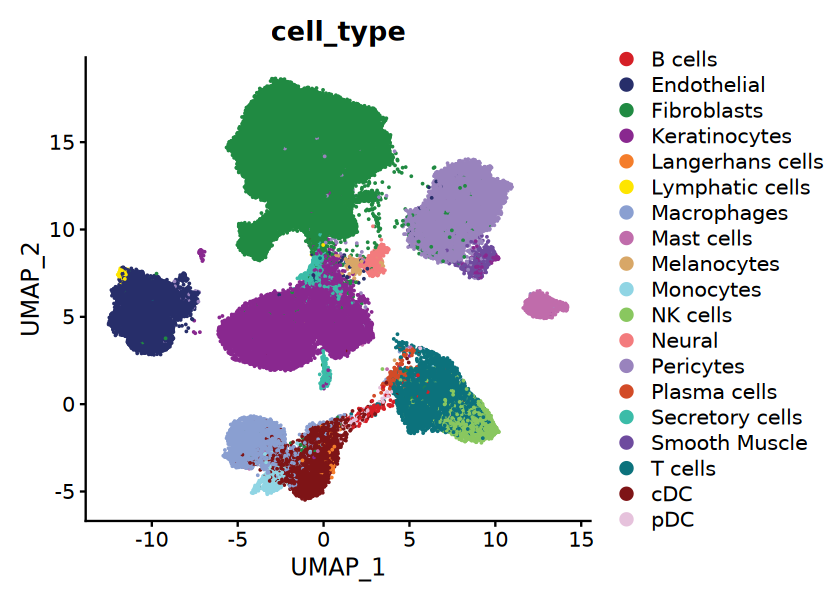

In [8]:
options(repr.plot.height = 5, repr.plot.width = 7)

DimPlot(sc.obj, group.by = "cell_type", cols = cols, shuffle = TRUE)

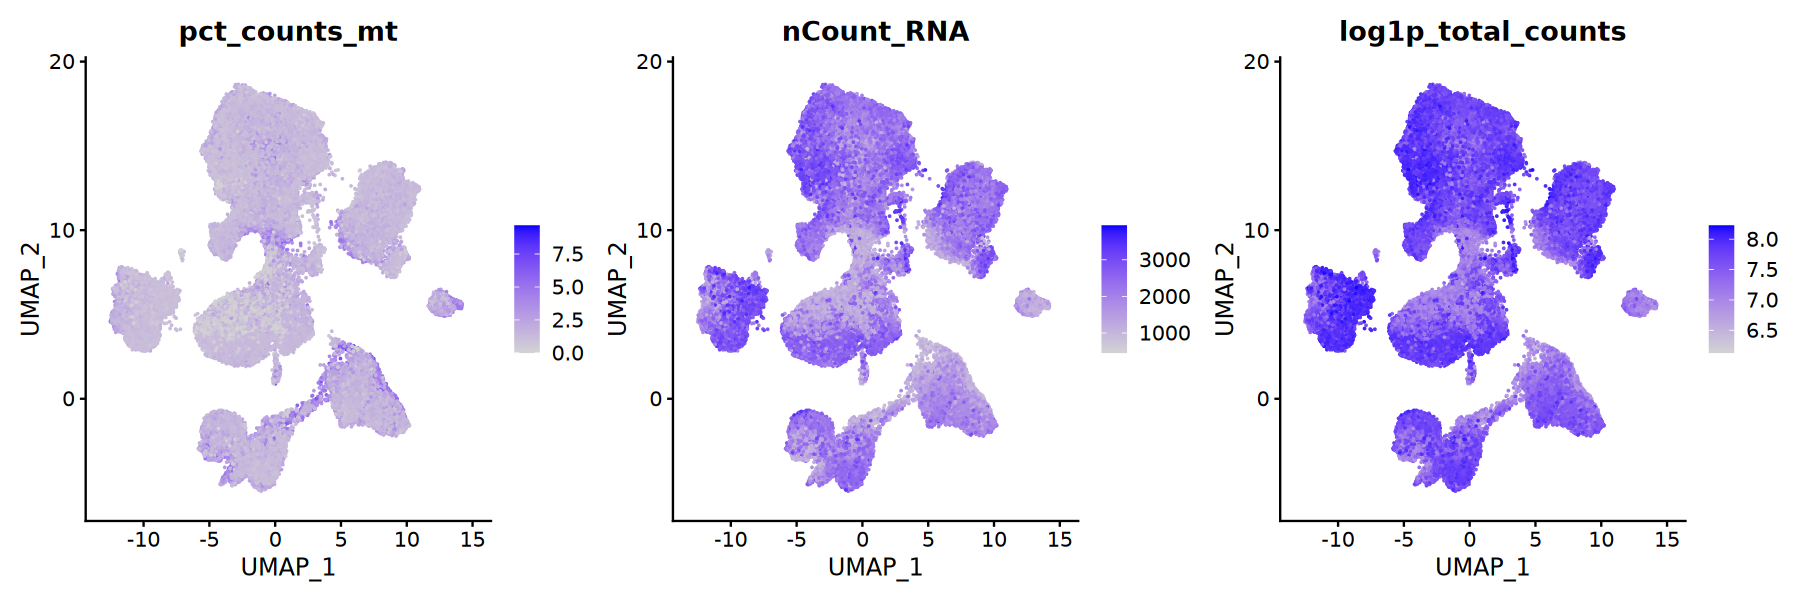

In [9]:
options(repr.plot.height = 5, repr.plot.width = 15)

FeaturePlot(sc.obj, features = c("pct_counts_mt", "nCount_RNA", "log1p_total_counts"), ncol = 3)

In [10]:
sc.obj <- sc.obj[, sample(colnames(sc.obj), size = 20000, replace=F)]

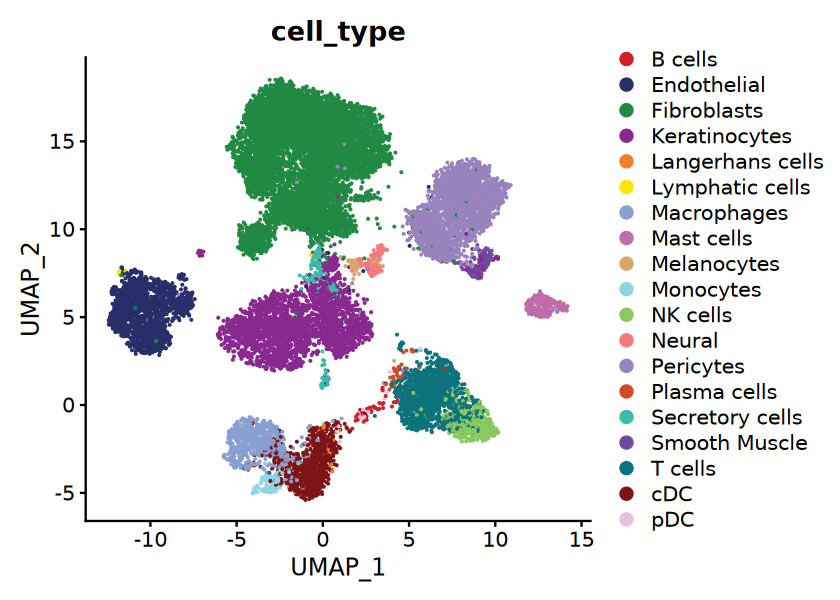

In [11]:
options(repr.plot.height = 5, repr.plot.width = 7)

DimPlot(sc.obj, group.by = "cell_type", cols = cols, shuffle = TRUE)

In [12]:
sample_list <- c('HC01', 'HC02', 'HC03', 'HC05',
               'SSc4733', 'SSc4994', 'SSc5380', 'SSc5722',
               'SSc-HL01', 'SSc-HL05', 'SSc-HL06', 'SSc-HL11',
               'SSc-HL13', 'SSc-HL25', 'SSc-HL33', 'SSc-HL35')

In [12]:
## HC01
st.obj <- readRDS(glue::glue("../../results/04_spatial/01_read_data/HC01.rds"))

obj.traint <- traint_v5(st_data = st.obj, 
                        sc_data = sc.obj, 
                        st_assay = 'Spatial', 
                        sc_assay='RNA', 
                        cell_names='cell_type')

Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 9004 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [15]:
st.obj

An object of class Seurat 
18085 features across 2035 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)
 2 layers present: counts, data
 1 image present: slice1

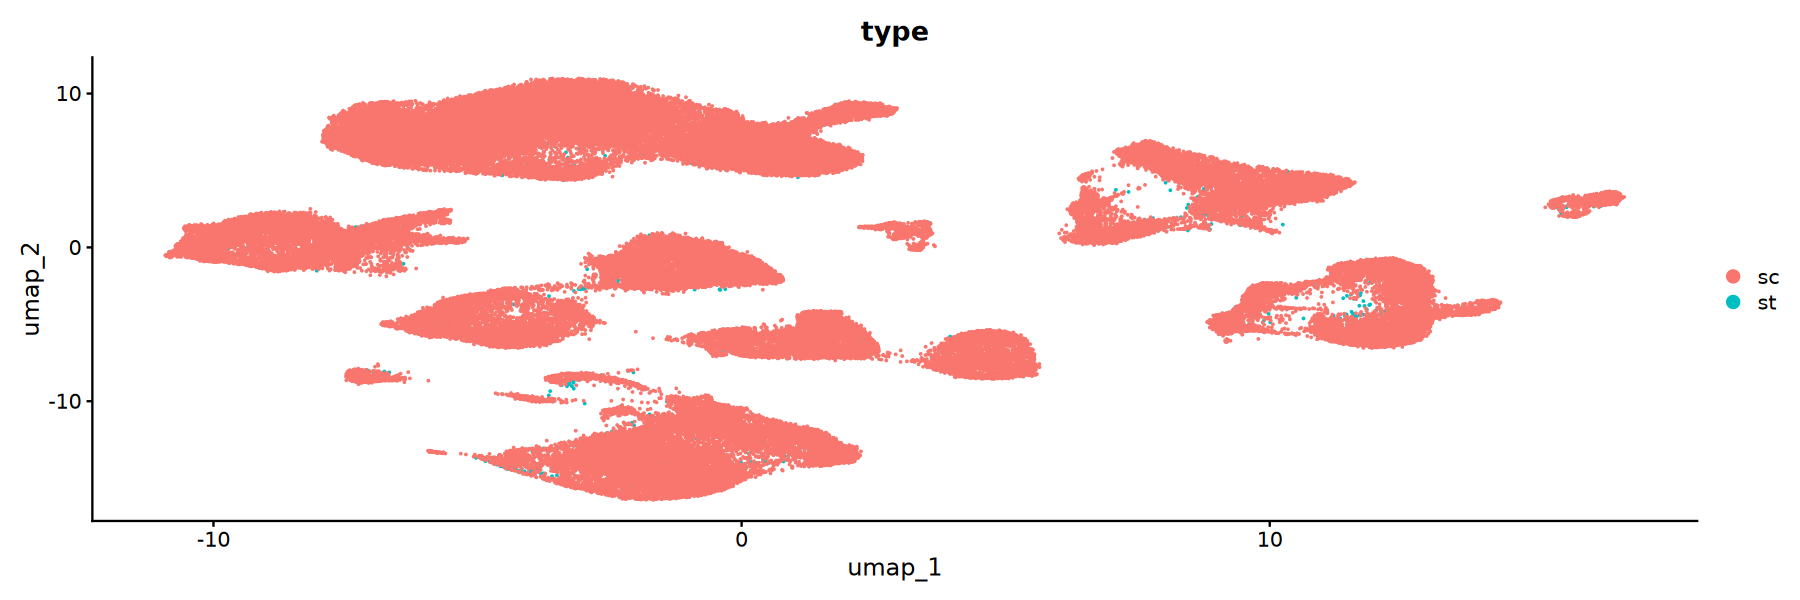

In [16]:
## We can check the co-embedding result to see if there is overlap between these two data modalities
DimPlot(obj.traint, group.by = "type") 

In [ ]:
st.obj.celltrek <- CellTrek::celltrek(st_sc_int=obj.traint, int_assay='traint', sc_data=sc.obj, sc_assay = 'RNA', 
                                      reduction='pca', intp=T, intp_pnt=5000, intp_lin=F, nPCs=30, ntree=1000, 
                                      dist_thresh=0.55, top_spot=5, spot_n=5, repel_r=20, repel_iter=20, keep_model=T)$celltrek

In [ ]:
st.obj.celltrek <- celltrek(st_sc_int=obj.traint, int_assay='traint', sc_data=sc.obj, sc_assay = 'RNA', 
                                reduction='pca', intp=T, intp_pnt=5000, 
                                intp_lin=F, 
                                nPCs=30, 
                                ntree=1000, 
                                dist_thresh=0.55, 
                                top_spot=5, 
                                spot_n=10, 
                                repel_r=20, 
                                repel_iter=20, keep_model=T)$celltrek
    
st.obj.celltrek$cell_type <- factor(st.obj.celltrek$cell_type, levels=sort(unique(st.obj.celltrek$cell_type)))
st.obj.celltrek <- NormalizeData(st.obj.celltrek)

In [ ]:
SpatialDimPlot(obj, group.by = 'cell_type', cols = cols, pt.size.factor = 0.5, image.alpha = 1)

In [ ]:
options(repr.plot.height = 7, repr.plot.width = 15)

for(sample in sample_list){
    st.obj <- readRDS(glue::glue("../../results/04_spatial/01_read_data/{sample}.rds"))
    DefaultAssay(st.obj) <- "Spatial"
    st.obj <- NormalizeData(st.obj)
    
    obj.traint <- traint_v5(st_data = st.obj, 
                        sc_data = sc.obj, 
                        st_assay = 'Spatial', 
                        sc_assay='RNA', cell_names='cell_type')
    
    ## We can check the co-embedding result to see if there is overlap between these two data modalities
    DimPlot(obj.traint, group.by = "cell_type", split.by = "type") 

    st.obj.celltrek <- celltrek(st_sc_int=obj.traint, int_assay='traint', sc_data=sc.obj, sc_assay = 'RNA', 
                                reduction='pca', intp=T, intp_pnt=5000, 
                                intp_lin=T, 
                                nPCs=30, 
                                ntree=1000, 
                                dist_thresh=0.55, 
                                top_spot=5, 
                                spot_n=10, 
                                repel_r=20, 
                                repel_iter=20, keep_model=T)$celltrek
    
    st.obj.celltrek$cell_type <- factor(st.obj.celltrek$cell_type, levels=sort(unique(st.obj.celltrek$cell_type)))
    st.obj.celltrek <- NormalizeData(st.obj.celltrek)
    
    saveRDS(st.obj.celltrek, glue::glue("../../results/04_spatial/03_run_celltrek/{sample}.rds"))
}

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 7905 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Distance between spots is: 199 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1  Cell6489  Cell6489    7120    5874
2 Cell12347 Cell12347    7120    5874
3 Cell20914 Cell20914    7120    5874
4 Cell33648 Cell33648    7120    5874
5 Cell33852 Cell33852    7120    5874
6 Cell51297 Cell51297    3837    4376
     id_raw    id_new  coord_x  coord_y
1  Cell6489  Cell6489 7068.266 5851.043
2 Cell12347 Cell12347 7167.820 5915.772
3 Cell20914 Cell20914 7092.782 5901.212
4 Cell33648 Cell33648 7111.056 5822.060
5 Cell33852 Cell33852 7106.118 5863.587
6 Cell51297 Cell51297 3835.400 4414.719
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 3086 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 100 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell17172 Cell17172    2022    2776
2 Cell30664 Cell30664    2022    2776
3 Cell30759 Cell30759    2022    2776
4 Cell30846 Cell30846    2022    2776
5 Cell31538 Cell31538    2022    2776
6 Cell34564 Cell34564    2022    2776
     id_raw    id_new  coord_x  coord_y
1 Cell17172 Cell17172 2182.874 2514.315
2 Cell30664 Cell30664 1994.348 2620.283
3 Cell30759 Cell30759 2233.964 2858.214
4 Cell30846 Cell30846 2079.152 2506.374
5 Cell31538 Cell31538 1944.138 2768.765
6 Cell34564 Cell34564 1939.390 2709.926
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 7310 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 81 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell64606 Cell64606    3319   20366
2 Cell74066 Cell74066    3319   20366
3 Cell74071 Cell74071    3319   20366
4 Cell74714 Cell74714    3319   20366
5 Cell74920 Cell74920    3319   20366
6 Cell75300 Cell75300    3319   20366
     id_raw    id_new  coord_x  coord_y
1 Cell64606 Cell64606 3218.164 20653.80
2 Cell74066 Cell74066 3351.517 20313.26
3 Cell74071 Cell74071 3510.176 20143.99
4 Cell74714 Cell74714 3179.810 20735.58
5 Cell74920 Cell74920 3470.794 20469.13
6 Cell75300 Cell75300 3345.677 20466.77
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 3732 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 103 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell68203 Cell68203    2679   37890
2 Cell89790 Cell89790    2679   37890
3 Cell89874 Cell89874    2679   37890
4 Cell91142 Cell91142    2679   37890
5 Cell47925 Cell47925    3875   36964
6 Cell66814 Cell66814    4327   36830
     id_raw    id_new  coord_x  coord_y
1 Cell68203 Cell68203 2657.845 38010.78
2 Cell89790 Cell89790 2743.083 37953.06
3 Cell89874 Cell89874 2625.820 38021.68
4 Cell91142 Cell91142 2810.463 38092.98
5 Cell47925 Cell47925 3846.809 36913.15
6 Cell66814 Cell66814 4333.957 36801.50
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 2284 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 160 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell86619 Cell86619    5321   27197
2 Cell86665 Cell86665    5321   27197
3 Cell88457 Cell88457    5321   27197
4 Cell88719 Cell88719    5321   27197
5 Cell92970 Cell92970    5321   27197
6 Cell15472 Cell15472    7947   28391
     id_raw    id_new  coord_x  coord_y
1 Cell86619 Cell86619 5410.142 27315.95
2 Cell86665 Cell86665 5278.305 27223.46
3 Cell88457 Cell88457 5390.317 27247.65
4 Cell88719 Cell88719 5236.003 27156.81
5 Cell92970 Cell92970 5259.376 27148.09
6 Cell15472 Cell15472 7875.965 28293.06
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 6248 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 100 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell65608 Cell65608    8174    4439
2 Cell71104 Cell71104    8174    4439
3 Cell86930 Cell86930    8174    4439
4 Cell89842 Cell89842    8174    4439
5  Cell2554  Cell2554    8372    5828
6  Cell6036  Cell6036    8372    5828
     id_raw    id_new  coord_x  coord_y
1 Cell65608 Cell65608 8205.798 4390.730
2 Cell71104 Cell71104 8166.444 4452.419
3 Cell86930 Cell86930 8140.937 4424.047
4 Cell89842 Cell89842 8188.614 4423.386
5  Cell2554  Cell2554 8345.219 5612.668
6  Cell6036  Cell6036 8237.751 5888.152
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 3973 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 199 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1  Cell3216  Cell3216    1884    1878
2  Cell3862  Cell3862    1884    1878
3 Cell11844 Cell11844    1884    1878
4 Cell25005 Cell25005    1884    1878
5 Cell32426 Cell32426    1884    1878
6 Cell34254 Cell34254    1884    1878
     id_raw    id_new  coord_x  coord_y
1  Cell3216  Cell3216 1819.362 1953.844
2  Cell3862  Cell3862 1955.617 1759.171
3 Cell11844 Cell11844 1772.457 1786.228
4 Cell25005 Cell25005 1998.465 1959.635
5 Cell32426 Cell32426 1955.959 1820.562
6 Cell34254 Cell34254 2007.900 1820.097
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 3448 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 140 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell30649 Cell30649    7333    6021
2 Cell67720 Cell67720    8438    8315
3 Cell72504 Cell72504    8438    8315
4 Cell94647 Cell94647    8438    8315
5 Cell95680 Cell95680    8438    8315
6 Cell95739 Cell95739    8438    8315
     id_raw    id_new  coord_x  coord_y
1 Cell30649 Cell30649 7370.092 5988.109
2 Cell67720 Cell67720 8425.250 8358.638
3 Cell72504 Cell72504 8445.132 8365.392
4 Cell94647 Cell94647 8401.308 8445.883
5 Cell95680 Cell95680 8386.231 8220.390
6 Cell95739 Cell95739 8346.332 8263.595
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 2114 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 100 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell12739 Cell12739    7261    2442
2 Cell20261 Cell20261    7261    2442
3 Cell21369 Cell21369    7261    2442
4 Cell40954 Cell40954    7261    2442
5 Cell19535 Cell19535    7020    3423
6 Cell23451 Cell23451    7020    3423
     id_raw    id_new  coord_x  coord_y
1 Cell12739 Cell12739 7153.276 2456.760
2 Cell20261 Cell20261 7097.244 2386.484
3 Cell21369 Cell21369 7022.447 2417.168
4 Cell40954 Cell40954 7186.335 2429.385
5 Cell19535 Cell19535 7333.153 3478.824
6 Cell23451 Cell23451 7182.058 3284.659
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 2333 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 199 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


Spatial Charting SC data...
Repelling points...
     id_raw    id_new coord_x coord_y
1 Cell11344 Cell11344    5673    4534
2 Cell79754 Cell79754    8788    2349
3 Cell92174 Cell92174    8788    2349
4 Cell28571 Cell28571    7057    5330
5 Cell30299 Cell30299    7057    5330
6 Cell38127 Cell38127    7057    5330
     id_raw    id_new  coord_x  coord_y
1 Cell11344 Cell11344 5705.071 4560.858
2 Cell79754 Cell79754 8806.308 2349.136
3 Cell92174 Cell92174 8818.563 2387.532
4 Cell28571 Cell28571 7095.524 5399.298
5 Cell30299 Cell30299 7105.084 5191.199
6 Cell38127 Cell38127 7056.013 5384.840
Creating Seurat Object... 
sc data...

Joining with `by = join_by(id_raw, id_new)`
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek_raw to celltrekraw_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from celltrek to celltrek_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca to pca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap to umap_”
Normalizing layer: counts

Normalizing layer: counts



Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Warning message:
“Adding image data that isn't associated with any assays”
Finding neighborhoods

Finding anchors

	Found 2798 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 


Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Scaling -> PCA -> UMAP... 
Distance between spots is: 110 
Interpolating...
Random Forest training... 
Random Forest prediction...  
Making distance matrix... 
Making graph... 
Pruning graph...


Joining with `by = join_by(Var1, Var2, value, val_rsc, Var1_type, Var2_type)`


In [ ]:
# options(repr.plot.height = 10, repr.plot.width = 10)

# SpatialDimPlot(st.obj.celltrek, pt.size.factor = 1, group.by = 'cell_type', cols = cols, image.alpha = 0)

In [ ]:
# options(repr.plot.height = 5, repr.plot.width = 12)

# p1 <- SpatialFeaturePlot(st.obj.celltrek, features = "VWF", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')
# p2 <- SpatialFeaturePlot(st.obj, features = "VWF", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')

# p1 + p2

In [ ]:
# options(repr.plot.height = 5, repr.plot.width = 12)

# p1 <- SpatialFeaturePlot(st.obj.celltrek, features = "DCN", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')
# p2 <- SpatialFeaturePlot(st.obj, features = "DCN", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')

# p1 + p2

In [ ]:
# options(repr.plot.height = 5, repr.plot.width = 12)

# p1 <- SpatialFeaturePlot(st.obj.celltrek, features = "SCARA5", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')
# p2 <- SpatialFeaturePlot(st.obj, features = "SCARA5", pt.size.factor = 1, image.alpha = 0) + scale_fill_viridis(option = 'A')

# p1 + p2